## Summary
In this project, we first followed the three-step instruction and made our own predictions on the sales, after fitting AR(1) model and built an autoregressive model based upon it. By conducting ADF tests on the results, we reached the conclusion that **even though the analyst's estimates are mean-reverting on the reported sales, the cointegrations between their walks are not high, indicating overshooting or undershooting problems.** Still, analyst's estimates are slightly better than our own predictions in step3, which may be largely due to the poor fitting of the models in our own predictions.

* **Stationarity:** We can first plot the time series to see if the trend is mean-reverting on 0, to get a rough idea of whether it is stationary. Then, by calculating the ADF statistics, we can get a more accurate evaluation of stationarity for both the absolute sales values and the spreads between estimates and reported sales. The reported sales, analyst's estimates and our own predicted sales are all not stationary, while spreads between analyst's estimates/our own predictions and the reported sales are stationary for most of the stocks.



* **Cointegration:** We learnt from ADF tests that analyst’s estimates are mean-reverting on the reported sales, but how correlated are the processes? By calculating cointegration statistics, we know that for 52% of the selected stocks’, the analyst’s estimates are significantly cointegrated to the reported sales data. Therefore, the precision of analyst’s predictions is not dominantly high to make the estimates pervasively applicable. 



* **Autocorrelation:** By calculating autocorrelations, we can easily find out whether each stock’s reported sales is significantly autocorrelated. By plotting the ACF and PACF graphs, we can further see on how many lags the time series are dependent, and choose the parameters p, q for fitting ARIMA models.



* **Select best model orders:** AIC and BIC are criterions used to evaluate the performances of models. By changing p, d, q for ARIMA(p,d,q) models, we get differnet AIC and BIC values. By choosing the lowest AIC/BIC value, we can find the best time series model to fit the data.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
#Time Series Analysis Packages
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Data Reading and Pre-processing

Read in the analyst's estimates Excel Worksheets.

In [3]:
sheets = pd.read_excel('Sales_Estimated.xlsx', sheet_name=None)
keys = list(sheets.keys())

'''
The imported Excel sheets is stored as an ordered dictionary, each key corresponds to one sheet.
'''

sheets

OrderedDict([('20060228',
                           Ticker Name Fiscal period          +1GQ          +2GQ  \
              0     0111145D US Equity       2005 Q4           NaN           NaN   
              1     0202445Q US Equity       2005 Q4           NaN           NaN   
              2     0203524D US Equity       2006 Q2  5.329167e+08  5.533333e+08   
              3     0226226D US Equity       2006 Q3           NaN           NaN   
              4     0231874D US Equity       2006 Q3           NaN           NaN   
              ...                  ...           ...           ...           ...   
              1495      ZBRA US Equity       2005 Q4  1.812500e+08  1.897500e+08   
              1496      ZION US Equity       2005 Q4  4.935000e+08  5.050000e+08   
              1497       ZLC US Equity       2006 Q2  5.320000e+08  4.850000e+08   
              1498       ZNT US Equity       2005 Q4           NaN           NaN   
              1499     ZQKSQ US Equity       2005 

In [4]:
'''
We can read every sheet as Pandas dataframe by calling the keys of the ordered dictionary.
'''
sheets['20060228'].head()

,Ticker Name,Fiscal period,+1GQ,+2GQ,+3GQ,+4GQ,+5GQ,+6GQ,+7GQ,+8GQ,+1FY,+2FY,+3FY
0,0111145D US Equity,2005 Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0202445Q US Equity,2005 Q4,NaN,NaN,2.400000e+08,2.500000e+08,267000000.0,2.696667e+08,2.643333e+08,2.783333e+08,1.073000e+09,1.160400e+09,NaN
2,0203524D US Equity,2006 Q2,5.329167e+08,5.533333e+08,5.563333e+08,5.901111e+08,581000000.0,6.138889e+08,6.126667e+08,6.480000e+08,NaN,NaN,NaN
3,0226226D US Equity,2006 Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.509030e+10,1.683100e+10,1.667400e+10
4,0231874D US Equity,2006 Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
sheets_copy = sheets.copy()
sheets_copy[keys[0]].set_index('Ticker Name', inplace=True)
sheets_copy[keys[0]].drop('Fiscal period', axis=1, inplace=True)
sheets_copy[keys[0]] = sheets_copy[keys[0]]['+1GQ']
sheets_copy[keys[0]].dropna(inplace=True)
sheets_copy[keys[0]].rename(columns={'+1GQ':keys[0]}, inplace=True)
set_20060228 = set(sheets_copy[keys[0]].index)

'''
Pre-processing for every sheet. Keep the one-month forward estimate and drop the null values. 
'''

for i in range(1, len(keys)):
    sheets_copy[keys[i]].set_index('Ticker Name', inplace=True)
    sheets_copy[keys[i]].drop('Fiscal period', axis=1, inplace=True)
    sheets_copy[keys[i]] = sheets_copy[keys[i]]['+1GQ']
    sheets_copy[keys[i]].dropna(inplace=True)
    sheets_copy[keys[i]].rename(columns={'+1GQ':keys[i]}, inplace=True)
    Tickers = set(sheets_copy[keys[i]].index)
    exec("set_%s = Tickers"%keys[i])
    
    '''
    Maintain a set called set_its, which is the intersection list of stocks that do not have null values across all the seasons.
    '''
    if i == 1:
        exec("set_its = set_%s & set_%s"%(keys[i],keys[i-1])) 
    else:
        exec("set_its = set_its & set_%s & set_%s"%(keys[i],keys[i-1]))

print(len(set_its))  #We ended up getting 611 stocks that have values across the whole period.

611


Read in the reported sales.

In [6]:
reported = pd.read_csv('Sales_reported.csv')
reported.rename(columns={'Ticker Pool':'Ticker Name'}, inplace=True)
reported.set_index('Ticker Name', inplace=True)
reported.head()

,20060228,20060531,20060831,20061130,20070228,20070531,20070831,20071130,20080229,20080530,...,20171130,20180228,20180531,20180831,20181130,20190228,20190531,20190830,20191127,20200302
Ticker Name,,,,,,,,,,,,,,,,,,,,,
0111145D US Equity,1357500000.00,1319400024.00,451299988.00,351100006.00,838200012.00,1334699951.00,556900024.00,365200012.00,919500000.00,1595699951.00,...,348400000.00,348400000.00,348400000.00,348400000.00,348400000.00,348400000.00,348400000.00,348400000.00,348400000.00,348400000.00
0202445Q US Equity,256332001.00,268415009.00,273774994.00,330117004.00,383063995.00,371992004.00,383174988.00,371174011.00,405213989.00,396204010.00,...,463032990.00,463032990.00,463032990.00,463032990.00,463032990.00,463032990.00,463032990.00,463032990.00,463032990.00,463032990.00
0203524D US Equity,544000000.00,547700012.00,572599976.00,541400024.00,501600006.00,431000000.00,455899994.00,471500000.00,499000000.00,453399994.00,...,374100006.00,374100006.00,374100006.00,374100006.00,374100006.00,374100006.00,374100006.00,374100006.00,374100006.00,374100006.00
0226226D US Equity,3738370117.00,3810949951.00,3273419922.00,3322790039.00,3284449951.00,3668863037.00,1941415039.00,2220927979.00,1906087036.00,2314304932.00,...,573973022.00,573973022.00,573973022.00,573973022.00,573973022.00,573973022.00,573973022.00,573973022.00,573973022.00,573973022.00
0231874D US Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
reported_copy = reported.copy()
reported_copy.dropna(how='any', inplace=True)
reported_copy.columns=pd.to_datetime(reported_copy.columns)
reported_copy.head()

,2006-02-28,2006-05-31,2006-08-31,2006-11-30,2007-02-28,2007-05-31,2007-08-31,2007-11-30,2008-02-29,2008-05-30,...,2017-11-30,2018-02-28,2018-05-31,2018-08-31,2018-11-30,2019-02-28,2019-05-31,2019-08-30,2019-11-27,2020-03-02
Ticker Name,,,,,,,,,,,,,,,,,,,,,
0111145D US Equity,1357500000.00,1319400024.00,451299988.00,351100006.00,838200012.00,1334699951.00,556900024.00,365200012.00,919500000.00,1595699951.00,...,348400000.00,348400000.00,348400000.00,348400000.00,348400000.00,348400000.00,348400000.00,348400000.00,348400000.00,348400000.00
0203524D US Equity,544000000.00,547700012.00,572599976.00,541400024.00,501600006.00,431000000.00,455899994.00,471500000.00,499000000.00,453399994.00,...,374100006.00,374100006.00,374100006.00,374100006.00,374100006.00,374100006.00,374100006.00,374100006.00,374100006.00,374100006.00
0536271D US Equity,388726013.00,414424988.00,431783997.00,471348999.00,518135010.00,496463013.00,522177979.00,539864990.00,505415985.00,505415985.00,...,505415985.00,505415985.00,505415985.00,505415985.00,505415985.00,505415985.00,505415985.00,505415985.00,505415985.00,505415985.00
0543122D US Equity,45601002.00,57403999.00,55619999.00,55969002.00,60441002.00,60441002.00,60441002.00,60441002.00,60441002.00,60441002.00,...,60441002.00,60441002.00,60441002.00,60441002.00,60441002.00,60441002.00,60441002.00,60441002.00,60441002.00,60441002.00
0562526D US Equity,212554001.00,238335999.00,234455002.00,202304001.00,200815994.00,251501007.00,251501007.00,251501007.00,251501007.00,251501007.00,...,251501007.00,251501007.00,251501007.00,251501007.00,251501007.00,251501007.00,251501007.00,251501007.00,251501007.00,251501007.00


In [8]:
'''
Similar to the intersection set for analyst's estimates, we get a set of stocks that \
have been in the pool from 2006/02/28 to 2020/03/02 and have no missing reported values.
We then calculate the intersection of these two sets, to get the final list of stocks that \
have no null values across the whole period.
'''

list_a = list(set(reported_copy.index).intersection(set_its))
len(list_a)

255

Keep only the entries for the selected stocks, ensuring there are no missing values in the dataframes used in the next section.

In [9]:
reported_copy = reported_copy.loc[list_a,:]
reported_copy = reported_copy.astype(float)

print(reported_copy.isnull().values.any()) #There is no missing values in reported sales dataframe now.
print(reported_copy.shape)

False
(255, 57)


In [10]:
for i in range(len(keys)):
    sheets_copy[keys[i]] = pd.DataFrame(sheets_copy[keys[i]]).loc[list_a,:]

df_estmt = pd.concat([sheets_copy[keys[0]], sheets_copy[keys[1]]], axis=1)
for i in range(2, len(keys)):
    df_estmt = pd.concat([df_estmt, sheets_copy[keys[i]]], axis=1)
df_estmt.columns = keys
df_estmt.columns=pd.to_datetime(df_estmt.columns)
df_estmt = df_estmt.astype(float)
print(df_estmt.isnull().values.any()) #There is no missing values now
print(df_estmt.shape)
df_estmt.head()

False
(255, 57)


,2006-02-28,2006-05-31,2006-08-31,2006-11-30,2007-02-28,2007-05-31,2007-08-31,2007-11-30,2008-02-29,2008-05-30,...,2017-11-30,2018-02-28,2018-05-31,2018-08-31,2018-11-30,2019-02-28,2019-05-31,2019-08-30,2019-11-27,2020-03-02
Ticker Name,,,,,,,,,,,,,,,,,,,,,
DRQ US Equity,100199000.0,1.105000e+08,1.150000e+08,1.216667e+08,1.280000e+08,1.320000e+08,1.280000e+08,1.342500e+08,1.463333e+08,1.358333e+08,...,9.987000e+07,9.550000e+07,9.451250e+07,8.573333e+07,8.651667e+07,9.388571e+07,9.668571e+07,1.045000e+08,1.056250e+08,1.042500e+08
TILE US Equity,261000000.0,2.535000e+08,2.543333e+08,2.806667e+08,2.735000e+08,2.894000e+08,2.691667e+08,2.883333e+08,2.720000e+08,2.840000e+08,...,2.564286e+08,2.347143e+08,2.745000e+08,3.071429e+08,3.458571e+08,3.038571e+08,3.611429e+08,3.466667e+08,3.451667e+08,3.084000e+08
MMS US Equity,170125000.0,1.878889e+08,1.852222e+08,1.754444e+08,1.775556e+08,2.048889e+08,2.082500e+08,1.941667e+08,2.098000e+08,2.110000e+08,...,6.250000e+08,6.163333e+08,5.930000e+08,5.874286e+08,6.743333e+08,7.604000e+08,7.576667e+08,7.561429e+08,8.003333e+08,8.256667e+08
ADTN US Equity,131500000.0,1.262308e+08,1.281750e+08,1.279444e+08,1.061875e+08,1.238750e+08,1.352667e+08,1.201111e+08,1.163571e+08,1.276154e+08,...,1.615000e+08,1.268333e+08,1.280000e+08,1.461667e+08,1.348333e+08,1.408333e+08,1.560000e+08,1.405000e+08,1.114000e+08,1.150000e+08
CACI US Equity,461000000.0,4.753846e+08,4.688462e+08,4.858750e+08,4.708667e+08,4.789333e+08,5.078333e+08,5.470000e+08,5.876667e+08,6.410714e+08,...,1.082846e+09,1.112154e+09,1.175667e+09,1.150364e+09,1.176700e+09,1.235222e+09,1.373300e+09,1.342500e+09,1.384000e+09,1.451556e+09


Take a peek at the reported sales and analyst's estimates of first five stocks' time series.

[Text(0.5, 1.0, 'Reported Sales -- Another 5 Stocks')]

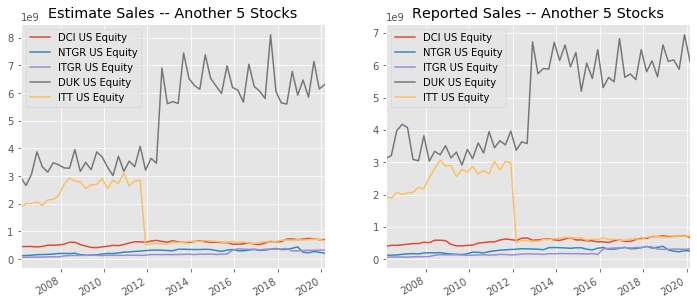

In [11]:
fig_peek, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, figsize = [12,5])

df_estmt.iloc[50:55].T.plot(ax=ax0)
ax0.legend(loc=0)
ax0.set(title="Estimate Sales -- Another 5 Stocks")

reported_copy.iloc[50:55].T.plot(ax=ax1)
ax1.legend(loc=0)
ax1.set(title="Reported Sales -- Another 5 Stocks")

## Step 1

In [12]:
params = {'beta_0': [], 'beta_1': []}

for i in range(reported_copy.shape[0]):
    mod = ARMA(reported_copy.iloc[i,:], order=(1,0))
    res = mod.fit()
    params['beta_0'].append(list(res.params)[0])
    params['beta_1'].append(list(res.params)[1])

df_predict1 = reported_copy.copy()
df_predict1['beta_0'] = pd.Series(params['beta_0'], index=df_predict1.index)
df_predict1['beta_1'] = pd.Series(params['beta_1'], index=df_predict1.index)

for i in range(1, len(df_predict1.columns)-2):
    df_predict1.iloc[:,i] = reported_copy.iloc[:, i-1] * df_predict1['beta_1'] + df_predict1['beta_0']

df_predict1.iloc[:,0] = 0
df_predict1.replace(0, np.NaN, inplace=True)
df_predict1.drop(['beta_0', 'beta_1'], axis=1, inplace=True)

In [13]:
df_new = pd.concat([df_estmt, reported_copy, df_predict1], axis=1, keys=['Estimate', 'Reported', 'Predict'])
df_new.head()

Estimate                                            \
                 2006-02-28    2006-05-31    2006-08-31    2006-11-30   
Ticker Name                                                             
DRQ US Equity   100199000.0  1.105000e+08  1.150000e+08  1.216667e+08   
TILE US Equity  261000000.0  2.535000e+08  2.543333e+08  2.806667e+08   
MMS US Equity   170125000.0  1.878889e+08  1.852222e+08  1.754444e+08   
ADTN US Equity  131500000.0  1.262308e+08  1.281750e+08  1.279444e+08   
CACI US Equity  461000000.0  4.753846e+08  4.688462e+08  4.858750e+08   

                                                                        \
                  2007-02-28    2007-05-31    2007-08-31    2007-11-30   
Ticker Name                                                              
DRQ US Equity   1.280000e+08  1.320000e+08  1.280000e+08  1.342500e+08   
TILE US Equity  2.735000e+08  2.894000e+08  2.691667e+08  2.883333e+08   
MMS US Equity   1.775556e+08  2.048889e+08  2.082500e+08  1.941667e+08   
ADTN US Equity  1.061875e+08  1.238750e+08  1.352667e+08  1.201111e+08   
CACI US Equity  4.708667e+08  4.789333e+08  5.078333e+08  5.470000e+08   

                                            ...       Predict                \
                  2008-02-29    2008-05-30  ...    2017-11-30    2018-02-28   
Ticker Name                                 ...                               
DRQ US Equity   1.463333e+08  1.358333e+08  ...  2.710324e+08  2.445885e+08   
TILE US Equity  2.720000e+08  2.840000e+08  ...  4.505576e+08  4.548893e+08   
MMS US Equity   2.098000e+08  2.110000e+08  ...  9.819049e+08  1.002277e+09   
ADTN US Equity  1.163571e+08  1.276154e+08  ...  2.699253e+08  2.702227e+08   
CACI US Equity  5.876667e+08  6.410714e+08  ...  2.003164e+09  1.951882e+09   

                                                                        \
                  2018-05-31    2018-08-31    2018-11-30    2019-02-28   
Ticker Name                                                              
DRQ US Equity   2.519005e+08  2.434637e+08  2.393287e+08  2.377906e+08   
TILE US Equity  4.615248e+08  4.421398e+08  4.746885e+08  5.009153e+08   
MMS US Equity   1.004513e+09  9.941942e+08  9.793235e+08  9.400766e+08   
ADTN US Equity  2.305237e+08  2.266529e+08  2.315597e+08  2.398846e+08   
CACI US Equity  1.953917e+09  1.989951e+09  2.035675e+09  2.031477e+09   

                                                                        
                  2019-05-31    2019-08-30    2019-11-27    2020-03-02  
Ticker Name                                                             
DRQ US Equity   2.417012e+08  2.388071e+08  2.479084e+08  2.521460e+08  
TILE US Equity  5.150752e+08  4.853171e+08  5.305305e+08  5.236108e+08  
MMS US Equity   1.045813e+09  1.117418e+09  1.111632e+09  1.135789e+09  
ADTN US Equity  2.397172e+08  2.422262e+08  2.507631e+08  2.221040e+08  
CACI US Equity  2.047164e+09  2.130007e+09  2.238307e+09  2.227881e+09  

[5 rows x 171 columns]

## Step 2

Model: **Sales<sub>t+1</sub> = $\lambda$ * Sales<sub>t</sub> + (1 - $\lambda$) * Sales Estimate <sub>t+1</sub>**\
Which can be converted into: **Sales<sub>t+1</sub> - Sales Estimate <sub>t+1</sub> = $\lambda$ * (Sales<sub>t</sub> - Sales Estimate <sub>t+1</sub>)**\
So that we can get $\lambda$ while implementing a constraint to the regression

In [14]:
Lam = []
for i in range(df_new.shape[0]):
    Endog = df_new['Reported'].iloc[i,:].shift(-1)[1:-1] - df_new['Estimate'].iloc[i,:].shift(-1)[1:-1]
    X = df_new['Predict'].iloc[i,:][1:-1] - df_new['Estimate'].iloc[i,:].shift(-1)[1:-1]
    #Exog = sm.add_constant(X, prepend=False)
    model = sm.OLS(Endog, X)
    res = model.fit()
    results_as_html_0 = res.summary().tables[0].as_html()
    results_as_html_1 = res.summary().tables[1].as_html()
    #AIC = pd.read_html(results_as_html_0, header=0, index_col=0)[0].iloc[4,2]
    #BIC = pd.read_html(results_as_html_0, header=0, index_col=0)[0].iloc[5,2]
    Lambda = pd.read_html(results_as_html_1, header=0, index_col=0)[0].iloc[0,0]
    Lam.append(Lambda)

#Regression summary for the last stock in the filtered pool. Note that without constant variable the model does not fit well.
print(res.summary()) 

                                 OLS Regression Results                                
Dep. Variable:          BCO US Equity   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):             -0.016
Method:                 Least Squares   F-statistic:                             0.1268
Date:                Tue, 19 May 2020   Prob (F-statistic):                       0.723
Time:                        13:39:23   Log-Likelihood:                         -1043.6
No. Observations:                  55   AIC:                                      2089.
Df Residuals:                      54   BIC:                                      2091.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

## Step 3

In [15]:
df_predict2 = reported_copy.copy()
df_predict2.iloc[:,0:2] = 0
df_predict2.replace(0, np.NaN, inplace=True)
df_predict2.head()

,2006-02-28,2006-05-31,2006-08-31,2006-11-30,2007-02-28,2007-05-31,2007-08-31,2007-11-30,2008-02-29,2008-05-30,...,2017-11-30,2018-02-28,2018-05-31,2018-08-31,2018-11-30,2019-02-28,2019-05-31,2019-08-30,2019-11-27,2020-03-02
Ticker Name,,,,,,,,,,,,,,,,,,,,,
DRQ US Equity,NaN,NaN,108475998.0,117766998.0,118301003.0,117681999.0,114700996.0,130423004.0,132751007.0,132412994.0,...,1.003460e+08,1.079710e+08,9.917300e+07,9.486100e+07,9.325700e+07,9.733500e+07,9.431700e+07,1.038080e+08,1.082270e+08,1.084540e+08
TILE US Equity,NaN,NaN,258678009.0,270612000.0,295917999.0,279282990.0,264962006.0,279471008.0,293347992.0,261735992.0,...,2.574310e+08,2.662100e+08,2.405630e+08,2.836260e+08,3.183250e+08,3.370590e+08,2.976880e+08,3.575070e+08,3.483520e+08,3.394820e+08
MMS US Equity,NaN,NaN,186595993.0,171798996.0,161138000.0,179076996.0,196557007.0,201873993.0,201949997.0,210584000.0,...,6.209030e+08,6.231480e+08,6.127870e+08,5.978550e+08,5.584460e+08,6.646190e+08,7.365200e+08,7.307100e+08,7.549660e+08,8.182290e+08
ADTN US Equity,NaN,NaN,122295998.0,132649994.0,109869003.0,110311996.0,123674004.0,123820999.0,118971001.0,119885002.0,...,1.851120e+08,1.265190e+08,1.208060e+08,1.280480e+08,1.403350e+08,1.400880e+08,1.437910e+08,1.563910e+08,1.140920e+08,1.157870e+08
CACI US Equity,NaN,NaN,477329010.0,467622986.0,476908997.0,473054993.0,511483002.0,553580017.0,577783997.0,567174988.0,...,1.085814e+09,1.087860e+09,1.124100e+09,1.170086e+09,1.165864e+09,1.181641e+09,1.264958e+09,1.373878e+09,1.363392e+09,1.395469e+09


In [16]:
for i in range(df_predict2.shape[0]):
    for j in range(1, df_predict2.shape[1]-1):
        df_predict2.iloc[i, j+1] = Lam[i] * df_new['Predict'].iloc[i, j] + (1 - Lam[i]) * df_new['Estimate'].iloc[i, j+1]

In [17]:
del df_new
df_new = pd.concat([df_estmt, reported_copy, df_predict1, df_predict1], \
                   axis=1, keys=['Estimate', 'Reported', 'Predict_step2', 'Predict_step3'])
df_new.head()

Estimate                                            \
                 2006-02-28    2006-05-31    2006-08-31    2006-11-30   
Ticker Name                                                             
DRQ US Equity   100199000.0  1.105000e+08  1.150000e+08  1.216667e+08   
TILE US Equity  261000000.0  2.535000e+08  2.543333e+08  2.806667e+08   
MMS US Equity   170125000.0  1.878889e+08  1.852222e+08  1.754444e+08   
ADTN US Equity  131500000.0  1.262308e+08  1.281750e+08  1.279444e+08   
CACI US Equity  461000000.0  4.753846e+08  4.688462e+08  4.858750e+08   

                                                                        \
                  2007-02-28    2007-05-31    2007-08-31    2007-11-30   
Ticker Name                                                              
DRQ US Equity   1.280000e+08  1.320000e+08  1.280000e+08  1.342500e+08   
TILE US Equity  2.735000e+08  2.894000e+08  2.691667e+08  2.883333e+08   
MMS US Equity   1.775556e+08  2.048889e+08  2.082500e+08  1.941667e+08   
ADTN US Equity  1.061875e+08  1.238750e+08  1.352667e+08  1.201111e+08   
CACI US Equity  4.708667e+08  4.789333e+08  5.078333e+08  5.470000e+08   

                                            ... Predict_step3                \
                  2008-02-29    2008-05-30  ...    2017-11-30    2018-02-28   
Ticker Name                                 ...                               
DRQ US Equity   1.463333e+08  1.358333e+08  ...  2.710324e+08  2.445885e+08   
TILE US Equity  2.720000e+08  2.840000e+08  ...  4.505576e+08  4.548893e+08   
MMS US Equity   2.098000e+08  2.110000e+08  ...  9.819049e+08  1.002277e+09   
ADTN US Equity  1.163571e+08  1.276154e+08  ...  2.699253e+08  2.702227e+08   
CACI US Equity  5.876667e+08  6.410714e+08  ...  2.003164e+09  1.951882e+09   

                                                                        \
                  2018-05-31    2018-08-31    2018-11-30    2019-02-28   
Ticker Name                                                              
DRQ US Equity   2.519005e+08  2.434637e+08  2.393287e+08  2.377906e+08   
TILE US Equity  4.615248e+08  4.421398e+08  4.746885e+08  5.009153e+08   
MMS US Equity   1.004513e+09  9.941942e+08  9.793235e+08  9.400766e+08   
ADTN US Equity  2.305237e+08  2.266529e+08  2.315597e+08  2.398846e+08   
CACI US Equity  1.953917e+09  1.989951e+09  2.035675e+09  2.031477e+09   

                                                                        
                  2019-05-31    2019-08-30    2019-11-27    2020-03-02  
Ticker Name                                                             
DRQ US Equity   2.417012e+08  2.388071e+08  2.479084e+08  2.521460e+08  
TILE US Equity  5.150752e+08  4.853171e+08  5.305305e+08  5.236108e+08  
MMS US Equity   1.045813e+09  1.117418e+09  1.111632e+09  1.135789e+09  
ADTN US Equity  2.397172e+08  2.422262e+08  2.507631e+08  2.221040e+08  
CACI US Equity  2.047164e+09  2.130007e+09  2.238307e+09  2.227881e+09  

[5 rows x 228 columns]

[Text(0.5, 1.0, 'Reported Sales -- 5 random Stocks')]

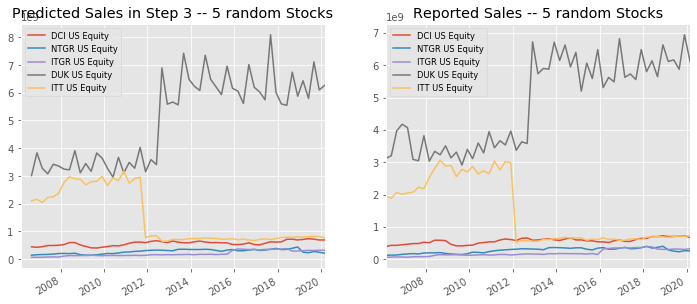

In [18]:
'''
Compare the time series of predicted sales in step3 and reported sales for 5 randomly chosen stocks in the selected list.
'''
fig_step3, axes = plt.subplots(nrows=1,ncols=2, figsize = [12,5])

df_predict2.iloc[50:55].T.plot(ax=axes[0])
axes[0].legend(loc=0, fontsize='small')
axes[0].set(title="Predicted Sales in Step 3 -- 5 random Stocks")

reported_copy.iloc[50:55].T.plot(ax=axes[1])
axes[1].legend(loc=0, fontsize='small')
axes[1].set(title="Reported Sales -- 5 random Stocks")

## Stationarity

**The graph below is the time series plot of the spread. With the horizontal line at y=0, we can get a rough perception about whether the spread is stationary. By changing the row number in .iloc[i, :], in which i ranges from 0 to 254, we can see the plots for different stocks.**

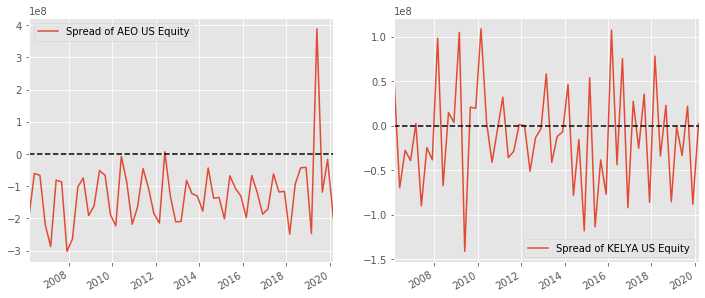

In [19]:
fig_stationarity, axes = plt.subplots(nrows=1,ncols=2, figsize = [12,5])

(df_new['Reported'].iloc[15,:] - df_new['Estimate'].iloc[15,:]).T.plot(ax=axes[0])
axes[0].legend(['Spread of ' + df_new['Reported'].iloc[15,:].name])
axes[0].axhline(y=0, color='k', linestyle='--')

(df_new['Reported'].iloc[35,:] - df_new['Estimate'].iloc[35,:]).T.plot(ax=axes[1])
axes[1].legend(['Spread of ' + df_new['Reported'].iloc[35,:].name])
axes[1].axhline(y=0, color='k', linestyle='--')

**ADF test is used to test the stationarity of time series. H0: The time series is not stationary.**

In [20]:
ADF_Estimate = []
for i in range(df_new.shape[0]):
    ADF_Estimate.append(adfuller(df_new['Estimate'].iloc[i,:])[1])
    
ADF_Reported = []
for i in range(df_new.shape[0]):
    ADF_Reported.append(adfuller(df_new['Reported'].iloc[i,:])[1])
    
ADF_Predict_step3 = []
for i in range(df_new.shape[0]):
    ADF_Predict_step3.append(adfuller(df_new['Predict_step3'].iloc[i,2:])[1])

ADF_ER_Spread = []
for i in range(df_new.shape[0]):
    ADF_ER_Spread.append(adfuller(df_new['Reported'].iloc[i,:]-df_new['Estimate'].iloc[i,:])[1])
    
ADF_PR_Spread = []
for i in range(df_new.shape[0]):
    ADF_PR_Spread.append(adfuller(df_new['Reported'].iloc[i,2:]-df_new['Predict_step3'].iloc[i,2:])[1])

In [21]:
w_estmt = np.round(np.sum(list(map(lambda x: x >= 0.1, ADF_Estimate))) / len(ADF_Estimate), 2)
w_reported = np.round(np.sum(list(map(lambda x: x >= 0.1, ADF_Reported))) / len(ADF_Reported), 2)
w_pred_step3 = np.round(np.sum(list(map(lambda x: x >= 0.1, ADF_Predict_step3))) / len(ADF_Predict_step3), 2)
w_ER_spread = np.round(np.sum(list(map(lambda x: x >= 0.1, ADF_ER_Spread))) / len(ADF_ER_Spread), 2)
w_PR_spread = np.round(np.sum(list(map(lambda x: x >= 0.1, ADF_PR_Spread))) / len(ADF_PR_Spread), 2)

[Text(0.5, 1.0, 'The p-values of ADF Tests on Predicted Sales in Step3')]

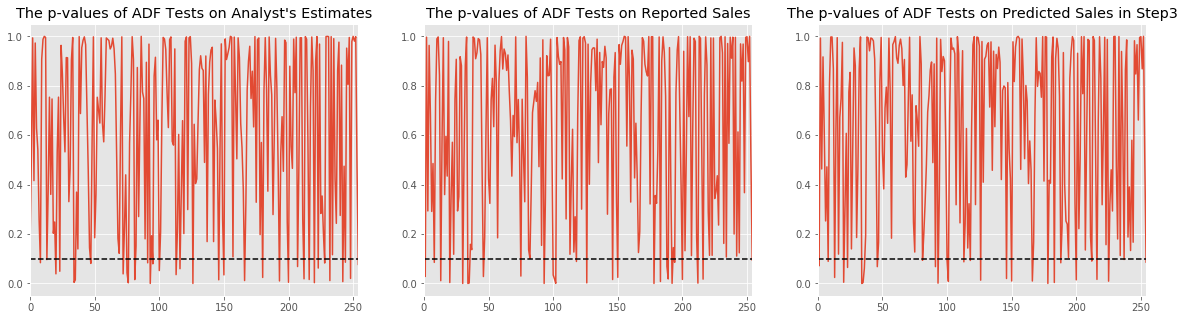

In [22]:
fig_ADF1, axes = plt.subplots(nrows=1,ncols=3, figsize = [20,5])

pd.Series(ADF_Estimate).plot(ax=axes[0])
axes[0].axhline(y=0.1, color='k', linestyle='--')
axes[0].set(title="The p-values of ADF Tests on Analyst's Estimates")

pd.Series(ADF_Reported).plot(ax=axes[1])
axes[1].axhline(y=0.1, color='k', linestyle='--')
axes[1].set(title="The p-values of ADF Tests on Reported Sales")

pd.Series(ADF_Predict_step3).plot(ax=axes[2])
axes[2].axhline(y=0.1, color='k', linestyle='--')
axes[2].set(title="The p-values of ADF Tests on Predicted Sales in Step3")

In [23]:
print("The weight of p-values that are larger than 10% for ADF tests on Analyst's Estimates is", w_estmt)
print("The weight of p-values that are larger than 10% for ADF tests on Reported Sales is", w_reported)
print("The weight of p-values that are larger than 10% for ADF tests on Predicted Sales in Step3 is", w_pred_step3)

The weight of p-values that are larger than 10% for ADF tests on Analyst's Estimates is 0.86
The weight of p-values that are larger than 10% for ADF tests on Reported Sales is 0.89
The weight of p-values that are larger than 10% for ADF tests on Predicted Sales in Step3 is 0.89


[Text(0.5, 1.0, 'Spread P-values: Predicted and Reported')]

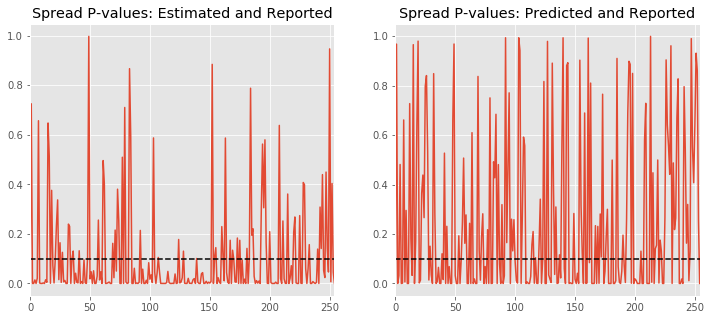

In [24]:
fig_ADF2, axes = plt.subplots(nrows=1,ncols=2, figsize = [12,5])

pd.Series(ADF_ER_Spread).plot(ax=axes[0])
axes[0].axhline(y=0.1, color='k', linestyle='--')
axes[0].set(title="Spread P-values: Estimated and Reported")

pd.Series(ADF_PR_Spread).plot(ax=axes[1])
axes[1].axhline(y=0.1, color='k', linestyle='--')
axes[1].set(title="Spread P-values: Predicted and Reported")

In [25]:
print("The weight of p-values that are larger than 10% for ADF tests on spread between analyst's estimates and reported sales is", w_ER_spread)
print("The weight of p-values that are larger than 10% for ADF tests on spread between predicted sales in step3 and reported sales is", w_PR_spread)

The weight of p-values that are larger than 10% for ADF tests on spread between analyst's estimates and reported sales is 0.28
The weight of p-values that are larger than 10% for ADF tests on spread between predicted sales in step3 and reported sales is 0.49


**Compared to original time series, the spreads are more likely to be stationary, which means most of the analyst's estimates and predicted sales in step3 are mean-reverting to the reported sales.**

## Cointegration

**We tested stationarity on spreads to see whether the analysts' estimates are accurate. However, calculating cointegration is technically a better way to find out correlation, from which we can not only know whether the estimates are mean-reverting on the reported sales, but also know how much the 'random' walks of estimates and reported sales are correlated.**

In [26]:
Coint_ER_Spread = []
for i in range(df_new.shape[0]):
    Coint_ER_Spread.append(coint(df_new['Reported'].iloc[i,:], df_new['Estimate'].iloc[i,:])[1])
    
Coint_PR_Spread=[]
for i in range(df_new.shape[0]):
    Coint_PR_Spread.append(coint(df_new['Reported'].iloc[i,2:], df_new['Predict_step3'].iloc[i,2:])[1])

w_ER_coint = np.round(np.sum(list(map(lambda x: x >= 0.1, Coint_ER_Spread))) / len(Coint_ER_Spread), 2)
w_PR_coint = np.round(np.sum(list(map(lambda x: x >= 0.1, Coint_PR_Spread))) / len(Coint_PR_Spread), 2)

[Text(0.5, 1.0, 'Cointegration P-values: Predicted and Reported')]

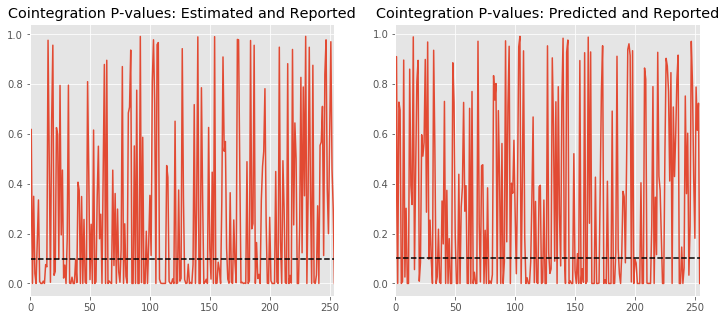

In [27]:
fig_coint, axes = plt.subplots(nrows=1,ncols=2, figsize = [12,5])

pd.Series(Coint_ER_Spread).plot(ax=axes[0])
axes[0].axhline(y=0.1, color='k', linestyle='--')
axes[0].set(title="Cointegration P-values: Estimated and Reported")

pd.Series(Coint_PR_Spread).plot(ax=axes[1])
axes[1].axhline(y=0.1, color='k', linestyle='--')
axes[1].set(title="Cointegration P-values: Predicted and Reported")

In [28]:
print("The weight of p-values that are larger than 10% for cointegration tests on spread between analyst's estimates and reported sales is", w_ER_coint)
print("The weight of p-values that are larger than 10% for cointegration tests on spread between predicted sales and reported sales is", w_PR_coint)

The weight of p-values that are larger than 10% for cointegration tests on spread between analyst's estimates and reported sales is 0.48
The weight of p-values that are larger than 10% for cointegration tests on spread between predicted sales and reported sales is 0.55


**Compared to the results of last section, the weight for PR increases slightly, while the same number for ER increases significantly from 28% to 48%. Therefore, even though the analysts' estimates generally are mean-reverting on reported sales, the co-movements may be overshooting or undershooting, indicating a lack of accuracy for almost half of the selected stocks.**

## Autocorrelation

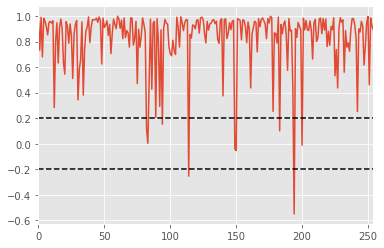

In [29]:
autocorr = []
for i in range(reported_copy.shape[0]):
    autocorr.append(reported_copy.iloc[i,:].autocorr())

pd.Series(autocorr).plot()
plt.axhline(y=0.2, color='k', linestyle="--")
plt.axhline(y=-0.2, color='k', linestyle="--")

It is clear to see that most of the selected stocks have high autocorrelations with absolute values higher than 0.2 in the graph above. 

Figure(864x360)
Figure(864x360)


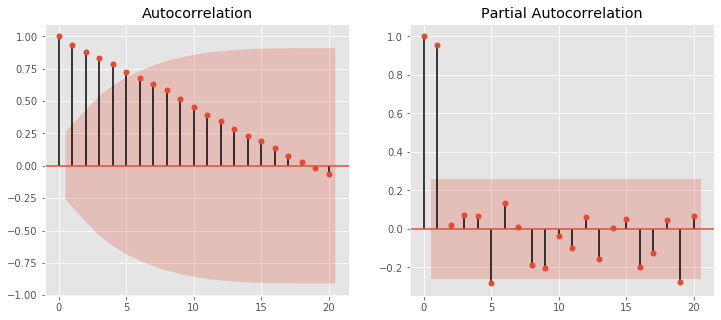

In [30]:
fig_autocorr, axes  = plt.subplots(nrows=1,ncols=2, figsize = [12,5])

print(plot_acf(reported_copy.iloc[5,:].T, lags=20, alpha=0.05, ax=axes[0]))
print(plot_pacf(reported_copy.iloc[5,:].T, lags=20, alpha=0.05, ax=axes[1]))

**The ACF and PACF graph of an example of the selected stocks indicate that, the PACF is censored after lag 2 (or lag 4), and ACF is censored after lag4. Therefore, AR(1) is not the best model. We should consider ARMA(4,2) or ARMA(4,4).**

Change the row number to see ACF and PACF plots for other stocks.

## Best Model Parameter Selection

**AIC and BIC adds penalties for the complexities of the model. Therefore, we can use AIC and BIC to select the best ARIMA model to fit the data in Step1. Below is an example.**

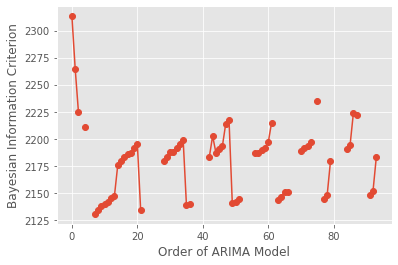

In [31]:
BIC = []
for p in range(7):
    for d in range(2):
        for q in range(7):
            try:
                mod = ARIMA(reported_copy.iloc[5,:], order=(p,d,q))
                res = mod.fit()
                BIC.append(res.bic)
            except Exception:
                BIC.append(np.NaN) 
            if BIC[-1] == min(BIC):
                p_best = p
                d_best = d
                q_best = q
            
plt.plot(range(7*2*7), BIC, marker='o')
plt.xlabel('Order of ARIMA Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

In [32]:
print(p_best, d_best, q_best)

0 1 0


Given the index of the lowest BIC, we can know the best model for this stock is ARIMA(3,1,1) process.

**On account of massive running time if fitting multiple models with different parameters for every stock, for now we only present the method, which can be tailored to complete the work for all the stocks with simple modifications.**